In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from datetime import datetime, timedelta
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows

from feature.scalers import ranged_scaler
from feature.engineering import *
from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE
from CARAT.components import *
from utils.utils import set_seed, logger

# Torch settings
"""torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = False
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.autograd.set_detect_anomaly(mode=False)

# Environment variables
os.environ['CUBLAS_WORKSPACE_CONFIG'] = '167772160'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"""

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
data = []
with open('data/TEP/idv8/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        data.append([float(col.strip()) for col in columns])


In [2]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [3]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))
df = make_stationary(df)

Column: x_1 | Final ADF: -3.5094 | p-value: 0.0005 | Diffs: 1
Column: x_2 | Final ADF: -3.8413 | p-value: 0.0001 | Diffs: 0
Column: x_3 | Final ADF: -28.3369 | p-value: 0.0000 | Diffs: 1
Column: x_4 | Final ADF: -27.3999 | p-value: 0.0000 | Diffs: 1
Column: x_5 | Final ADF: -21.1317 | p-value: 0.0000 | Diffs: 1
Column: x_6 | Final ADF: -20.4168 | p-value: 0.0000 | Diffs: 1
Column: x_7 | Final ADF: -4.7582 | p-value: 0.0000 | Diffs: 1
Column: x_8 | Final ADF: -27.7303 | p-value: 0.0000 | Diffs: 1
Column: x_9 | Final ADF: -21.2434 | p-value: 0.0000 | Diffs: 1
Column: x_10 | Final ADF: -4.9323 | p-value: 0.0000 | Diffs: 1
Column: x_11 | Final ADF: -3.7518 | p-value: 0.0002 | Diffs: 1
Column: x_12 | Final ADF: -22.3843 | p-value: 0.0000 | Diffs: 1
Column: x_13 | Final ADF: -4.7522 | p-value: 0.0000 | Diffs: 1
Column: x_14 | Final ADF: -26.6548 | p-value: 0.0000 | Diffs: 1
Column: x_15 | Final ADF: -17.9842 | p-value: 0.0000 | Diffs: 1
Column: x_16 | Final ADF: -4.7251 | p-value: 0.0000 | D

In [4]:
df=df.to_pandas()

In [5]:
#random dates, trivial for this exercise

start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [6]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [7]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_26'>

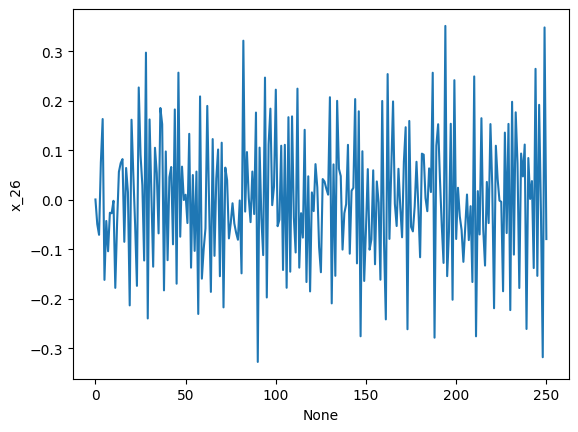

In [8]:
sns.lineplot(data=df,y='x_26',x=df.index)

<Axes: xlabel='None', ylabel='x_4'>

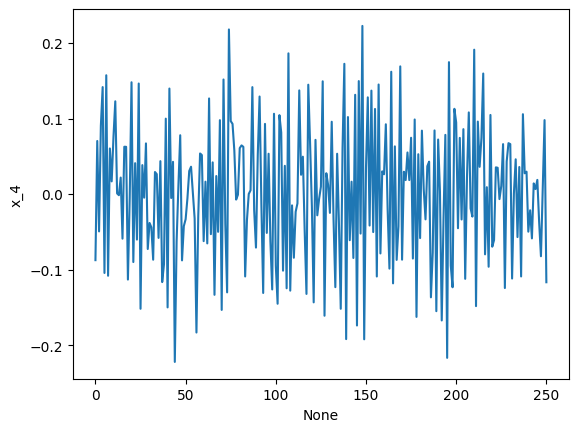

In [9]:
sns.lineplot(data=df,y='x_4',x=df.index)

In [10]:
df = df[['x_3', 'x_4','x_6','x_9','x_14','x_21','x_23','x_24','x_26','x_31','x_32']]

In [11]:
df.shape

(251, 11)

In [12]:
normal = df[100:]
bad = df[0:100]

In [13]:
df.columns

Index(['x_3', 'x_4', 'x_6', 'x_9', 'x_14', 'x_21', 'x_23', 'x_24', 'x_26',
       'x_31', 'x_32'],
      dtype='object')

In [14]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

# Pretraining

In [15]:
import torch
import random
import numpy as np

# Define the seed value
seed = 42

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for CUDA (if using GPUs)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set seed for Python's random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Ensure deterministic behavior for PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [ ]:
TIME_STEPS = 7
BATCH_SIZE = 25
hidden_dim = 96
latent_dim = 8
edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
cols = df.columns.tolist()
for i in range(30):
    total_checked+=1

    dataset_bad = TimeSeriesDataset(df, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=df.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1], device=device,
                        time_steps=TIME_STEPS, prior_adj=None,instantaneous_weight=0.2,use_attention=False).to(device)
    optimizer = torch.optim.AdamW(fine_tuned.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=7, min_lr=1e-5)
   
    # Train on nominal data
    # print("Pretraining on nominal data...")
    fine_tuned.train_model(dataloader_bad, optimizer,scheduler=scheduler, num_epochs=400, patience=20,
                           BATCH_SIZE=BATCH_SIZE,rho_max=3,alpha_max=1.5
                          )
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes1 = fine_tuned.infer_causal_effect(X_data,T_data,'x_24',cols,non_causal_indices=[])
    causes2 = fine_tuned.infer_causal_effect(X_data,T_data,'x_3',cols,non_causal_indices=[])
    df_concat = pd.concat((causes1, causes2))
    by_row_index = df_concat.groupby(df_concat.index)
    causes = by_row_index.mean()
        
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    edge_cause_2 = causes.sort_values(by='causes',ascending=False)[0:3].index[1]
    edge_cause_3 = causes.sort_values(by='causes',ascending=False)[0:3].index[2]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    instant_cause_2 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[1]
    instant_cause_3 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[2]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    lag_cause_2 = causes.sort_values(by='lagged',ascending=False)[0:3].index[1]
    lag_cause_3 = causes.sort_values(by='lagged',ascending=False)[0:3].index[2]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    counterfactual_cause_2 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[1]
    counterfactual_cause_3 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[2]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    rr_cause_2 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[1]
    rr_cause_3 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[2]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    total_score_cause_2=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[1]
    total_score_cause_3=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[2]
    
    if (edge_cause_1 in ['x_26','x_4']) | (edge_cause_2 in ['x_26','x_4']) | (edge_cause_3 in ['x_26','x_4']):
        edge_correct+=1
    
    if (  total_score_cause_1 in ['x_26','x_4']) | (total_score_cause_2 in ['x_26','x_4']) | ( total_score_cause_3 in ['x_26','x_4']):
        total_correct+=1
    
    if (counterfactual_cause_1 in ['x_26','x_4']) | (counterfactual_cause_2 in ['x_26','x_4']) | (counterfactual_cause_3 in ['x_26','x_4']):
        counterfactual_correct+=1
    
    if (instant_cause_1 in ['x_26','x_4']) | (instant_cause_2 in ['x_26','x_4']) |( instant_cause_3 in ['x_26','x_4'] ):
        instantaneous_correct+=1
    
    if (lag_cause_1 in ['x_26','x_4']) | (lag_cause_2 in ['x_26','x_4'])  | (lag_cause_3 in ['x_26','x_4']):
        lagged_correct+=1
    
    if (rr_cause_1 in ['x_26','x_4']) | (rr_cause_2 in ['x_26','x_4']) | (rr_cause_3 in ['x_26','x_4']):
        rr_correct+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


Epoch 1: Loss = 740.6763
Recon Loss = 114.2312, KL Loss = 0.0000, Lagrangian Loss = 442.3916
